# LACSS Inference Demo

This is a small notebook demonstrating the workflow of applying an LACSS model to make segmentation prediction.




## Setting up the environment

In [1]:
!pip install git+https://github.com/jiyuuchc/lacss

  Cloning https://github.com/jiyuuchc/lacss to /tmp/pip-req-build-chy1jg1d
  Running command git clone --filter=blob:none --quiet https://github.com/jiyuuchc/lacss /tmp/pip-req-build-chy1jg1d
  Resolved https://github.com/jiyuuchc/lacss to commit d714d4c08ffc0925a79bfbba308f32b4775f84f1
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of flax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of orbax-checkpoint to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.8/451.8 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.5/39.5 MB 14.5

In [1]:
!pip install numpy==1.23.5

In [2]:
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import label2rgb

from lacss.utils import show_images

## Load a pre-trained model

In [3]:
from lacss.deploy import model_urls
from lacss.deploy.predict import Predictor

!wget -c {model_urls["lacss3-small"]} -O model_file

predictor = Predictor("model_file")

--2025-04-07 11:46:22--  https://huggingface.co/jiyuuchc/lacss3-small/resolve/main/lacss3-small
Resolving huggingface.co (huggingface.co)... 13.35.202.40, 13.35.202.121, 13.35.202.97, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.40|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/af/fa/affaa0e7bbd4b52a245a861f7213eefddc32dbf1c758705fd66550201b5a41dc/b0636d036c7afe61544c62b40c5bffd0591743f6b7ed29e57d30141681889d8e?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27lacss3-small%3B+filename%3D%22lacss3-small%22%3B&Expires=1744029982&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NDAyOTk4Mn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2FmL2ZhL2FmZmFhMGU3YmJkNGI1MmEyNDVhODYxZjcyMTNlZWZkZGMzMmRiZjFjNzU4NzA1ZmQ2NjU1MDIwMWI1YTQxZGMvYjA2MzZkMDM2YzdhZmU2MTU0NGM2MmI0MGM1YmZmZDA1OTE3NDNmNmI3ZWQyOWU1N2QzMDE0MTY4MTg4OWQ4ZT9yZXNwb25zZS1jb250ZW50LWRpc3Bv

/usr/local/lib/python3.11/dist-packages/lacss/modules/common.py:44: UserWarning: Adding missing field full_scale_output
  warnings.warn(f"Adding missing field {key}")


## Also download some image data

We will download some microscopy images from the [Cell Image Library](http://www.cellimagelibrary.org/home) collection.

In [4]:
!wget -c https://data.mendeley.com/public-files/datasets/894mmsd9nj/files/568e524f-9a95-45a6-9f80-3619969c2a37/file_downloaded -O images.zip

import zipfile

data_path = 'image_data'
with zipfile.ZipFile('images.zip', "r") as f:
    f.extractall(data_path)

--2025-04-07 11:46:28--  https://data.mendeley.com/public-files/datasets/894mmsd9nj/files/568e524f-9a95-45a6-9f80-3619969c2a37/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/305fe4d3-50bf-4e9b-89c7-fca353116d70 [following]
--2025-04-07 11:46:29--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/305fe4d3-50bf-4e9b-89c7-fca353116d70
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 3.5.68.10, 52.218.36.171, 52.92.20.130, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|3.5.68.10|:443... c

## Make a prediction

NOTE: The first time running a prediction will some time. This is because LACSS is model based on [JAX](https://jax.readthedocs.io/en/latest/) framework, which performs **just-in-time compilation** of the model the first time we run it. Rerun the cell below a second time will be much faster.

[Text(0.5, 1.0, 'Input'),
 Text(0.5, 1.0, 'Prediction'),
 Text(0.5, 1.0, 'Ground Truth')]

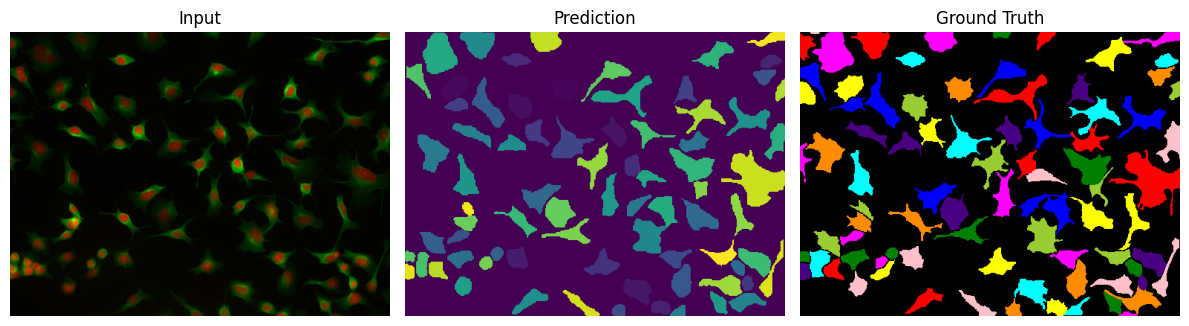

In [5]:
image = imageio.imread("image_data/test/000_img.png")
gt = imageio.imread("image_data/test/000_masks.png")

label = predictor.predict(
    image, reshape_to=[230, 307], nms_iou=0.4,
)["pred_label"]

show_images([
    image,
    label,
    label2rgb(gt, bg_label=0),
])

titles = ['Input', "Prediction", "Ground Truth"]
[ax.set_title(title) for ax, title in zip(plt.gcf().get_axes(), titles)]

In [6]:
import json
import numpy as np
from skimage.measure import label
from pycocotools.coco import COCO

# Загрузка COCO аннотаций
coco_annotations = "dataset/annotations/instances_default.json"
coco = COCO(coco_annotations)

# Получение списка изображений
image_ids = coco.getImgIds()

# Загрузка изображения и масок
def load_image_and_masks(img_id):
    img_info = coco.loadImgs(img_id)[0]
    image_path = f"dataset/images/{img_info['file_name']}"
    image = imageio.imread(image_path)

    ann_ids = coco.getAnnIds(imgIds=img_id)
    annotations = coco.loadAnns(ann_ids)

    masks = []
    for ann in annotations:
        mask = coco.annToMask(ann)
        masks.append(mask)

    # Объединение масок в одну (каждому объекту — уникальный номер)
    gt_mask = np.zeros(image.shape[:2], dtype=np.uint16)
    for i, mask in enumerate(masks, start=1):
        gt_mask[mask > 0] = i

    return image, gt_mask

# Пример загрузки одного изображения
image, gt_mask = load_image_and_masks(image_ids[0])

loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


In [15]:
import tensorflow as tf
from lacss.train import Trainer
from lacss.data import Dataset

# 1. Подготовка датасета
def data_generator():
    for img_id in image_ids:
        image, gt_mask = load_image_and_masks(img_id)
        yield {"image": image, "mask": gt_mask}

dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature={
        "image": tf.TensorSpec(shape=(None, None, 3)),
        "mask": tf.TensorSpec(shape=(None, None), dtype=tf.uint16),
    }
).batch(2)  # батч размером 2

# 2. Загрузка предобученной модели
trainer = Trainer(model="lacss")

# 3. Дообучение
trainer.fit(
    dataset,
    epochs=10,
    steps_per_epoch=len(image_ids) // 2,
)

ModuleNotFoundError: No module named 'xtrain'